# Electricity emissions calculation 
## based on DA RFNBO June 2022

This notebook aims at providing some details on the calculation of the electricity emissions based on DA RFNBO Jan 2023.

The source data can be accessed directly:
- [here](https://ec.europa.eu/eurostat/databrowser/view/NRG_BAL_C__custom_3055577/default/table?lang=en), 
- by using the Eurostat API (but the amount of data per request that can be downloaded is limited),
- by downloading the full dataset [here](https://ec.europa.eu/eurostat/web/energy/data/database).

Useful explanation of the flows and their definition can be accessed [here](https://ec.europa.eu/eurostat/documents/38154/4956218/Energy-Balance-Formulas.xlsx/cc2f9ade-5c0b-47b5-b83d-c05fe86eef6c).

### Scope and definition of RFNBO carbon intensity:

The carbon footprint of RFNBO (Renewable Fuel of Non Biological Origin) is calculated considering the following points:
- In the case of Combined Heat and Power (CHP), the fuels used for heat produced in CHP shall be counted by considering alternative heat production with average overall efficiencies of 85%, while the rest shall be attributed to electricity generation.
- No fuels are associated with electricity production from renewables that include hydro, solar, wind and geothermal.
- The emissions from the construction and decommissioning and waste management of electricity producing facilities are not considered. Thus, the carbon equivalent emissions associated with the renewable electricity (wind, solar, hydro and geothermal) production are considered to be equal to zero.
- The CO<sub>2</sub> equivalent emissions from gross electricity production should include upstream emissions from JEC WTW v5 (Prussi et all, 2020) listed in Table 3 of the DA and the default emission factors for stationary combustion from IPCC Guidelines for National Greenhouse Gas Inventories (IPCC 2006) listed in Tables 1 and 2.

The calculation of the carbon intensity of electricity shall be done following the formula:

$𝑒_{𝑔𝑟𝑜𝑠𝑠\ 𝑝𝑟𝑜𝑑} = \sum_{i=1}^k (𝑐_{𝑢𝑝𝑠, i} + 𝑐_{𝑐𝑜𝑚𝑏, i}) ∗ 𝐵_𝑖 $

where: 
- $𝑒_{𝑔𝑟𝑜𝑠𝑠\ 𝑝𝑟𝑜𝑑}$ – CO<sub>2</sub> equivalent emissions [𝑔CO<sub>2</sub>𝑒𝑞]
- $𝑐_{𝑢𝑝𝑠, i}$ – upstream CO<sub>2</sub> equivalent emission factors [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]
- $𝑐_{𝑐𝑜𝑚𝑏, i}$ – CO<sub>2</sub> equivalent emission factors from fuels combustion [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]
- $𝐵_𝑖$ – fuel consumption for electricity generation [𝑀𝐽]
- $ 𝑖 = 1⋯𝑘$ –fuels used for electricity production

The amount of net electricity production is determined by the gross electricity production, substracting the own electricity consumption in the power plant and  electricity input to the pump hydro storage (in Eurostat, the gross electricity production contains the output of pumped hydro, so substracting the input yields the net produced electricity after storage).

$𝐸_{𝑛𝑒𝑡}=𝐸_{𝑔𝑟𝑜𝑠𝑠\ prod}−𝐸_{𝑜𝑤𝑛}−𝐸_{𝑝𝑢𝑚𝑝}$

where: 
- $𝐸_{net}$ – net electricity production [𝑀𝐽]
- $𝐸_{gross\ prod}$ – gross electricity production [𝑀𝐽]
- $𝐸_{𝑜𝑤𝑛}$ – own internal electricity consumption in power plant [𝑀𝐽]
- $𝐸_{𝑝𝑢𝑚𝑝}$ – electricity for pumping [𝑀𝐽]

The carbon intensity of net produced electricity shall be the total gross GHG emitted for producing or using the net electricity:

$ 𝐶𝐼 = 𝑒_{gross\ prod} \big/ {E_{net}} $ 

where: 
- $𝐶𝐼$ – CO<sub>2</sub> equivalent emissions from electricity production [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]


In [ ]:
%pip install -r requirements.txt

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

plt.style.use("ggplot")

# 1. Greenhouse gas emissions per unit of energy per pathway

## Data formating

In [9]:
# Importing data from emission_factors_energy_products
df_fuels = pd.read_csv(
    "data/emission_factors_energy_products.csv",
    header=[0, 1],
    index_col=1,
    delimiter=";",
)
df_fuels.head()

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories Source: Eurostat  \
label                                                                                                                      siec   
Solid fossil fuels                                                                                              C0000X0350-0370   
Anthracite                                                                                                                C0110   
Coking coal                                                                                                               C0121   
Other bituminous coal                                                                                                     C0129   
Sub-bituminous coal                                                                                                       C0210   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories    kg/TJ  \
label                                                                                                             efCO2   
Solid fossil fuels                                                                                                  NaN   
Anthracite                                                                                                      98300.0   
Coking coal                                                                                                     94600.0   
Other bituminous coal                                                                                           94600.0   
Sub-bituminous coal                                                                                             96100.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efCH4   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.0   
Coking coal                                                                                                      1.0   
Other bituminous coal                                                                                            1.0   
Sub-bituminous coal                                                                                              1.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efN2O   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.5   
Coking coal                                                                                                      1.5   
Other bituminous coal                                                                                            1.5   
Sub-bituminous coal                                                                                              1.5   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories kg CO2eq / TJ  
label                                                                                                             UpstreamE3  
Solid fossil fuels                                                                                                       NaN  
Anthracite                                                                                                           16000.0  
Coking coal                   

In [10]:
# Extracting emmission factor
df_ef = df_fuels["kg/TJ"]
df_ef.head()
df_ef.columns = [col.replace("ef", "") for col in df_ef.columns]
df_ef.head()

,CO2,CH4,N2O
Solid fossil fuels,NaN,NaN,NaN
Anthracite,98300.0,1.0,1.5
Coking coal,94600.0,1.0,1.5
Other bituminous coal,94600.0,1.0,1.5
Sub-bituminous coal,96100.0,1.0,1.5


In [11]:
# Calculating the equivalent carbon footprint
GWP_factors = {"CO2": 1, "CH4": 25, "N2O": 298}
df_ef_CO2eq = df_ef.multiply(GWP_factors)
df_ef_CO2eq["Total"] = df_ef_CO2eq.sum(axis=1)

# Concatenating all data together
df_ef_CO2eq = pd.concat([df_ef_CO2eq], axis=1, keys=["kg CO2eq / TJ (combustion)"])
df_fuels = pd.concat([df_fuels, df_ef_CO2eq], axis=1)
df_fuels.head()

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories Source: Eurostat  \
label                                                                                                                      siec   
Solid fossil fuels                                                                                              C0000X0350-0370   
Anthracite                                                                                                                C0110   
Coking coal                                                                                                               C0121   
Other bituminous coal                                                                                                     C0129   
Sub-bituminous coal                                                                                                       C0210   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories    kg/TJ  \
label                                                                                                             efCO2   
Solid fossil fuels                                                                                                  NaN   
Anthracite                                                                                                      98300.0   
Coking coal                                                                                                     94600.0   
Other bituminous coal                                                                                           94600.0   
Sub-bituminous coal                                                                                             96100.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efCH4   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.0   
Coking coal                                                                                                      1.0   
Other bituminous coal                                                                                            1.0   
Sub-bituminous coal                                                                                              1.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efN2O   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.5   
Coking coal                                                                                                      1.5   
Other bituminous coal                                                                                            1.5   
Sub-bituminous coal                                                                                              1.5   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories kg CO2eq / TJ  \
label                                                                                                             UpstreamE3   
Solid fossil fuels                                                                                                       NaN   
Anthracite                                                                                                           16000.0   
Coking coal               

## Saving and loading as a pickle

In [19]:
# Saving data in a pickle file
df_fuels.to_pickle("data/df_fuels.pkl")

In [6]:
df_fuels = pd.read_pickle("data/df_fuels.pkl")

## Data observation

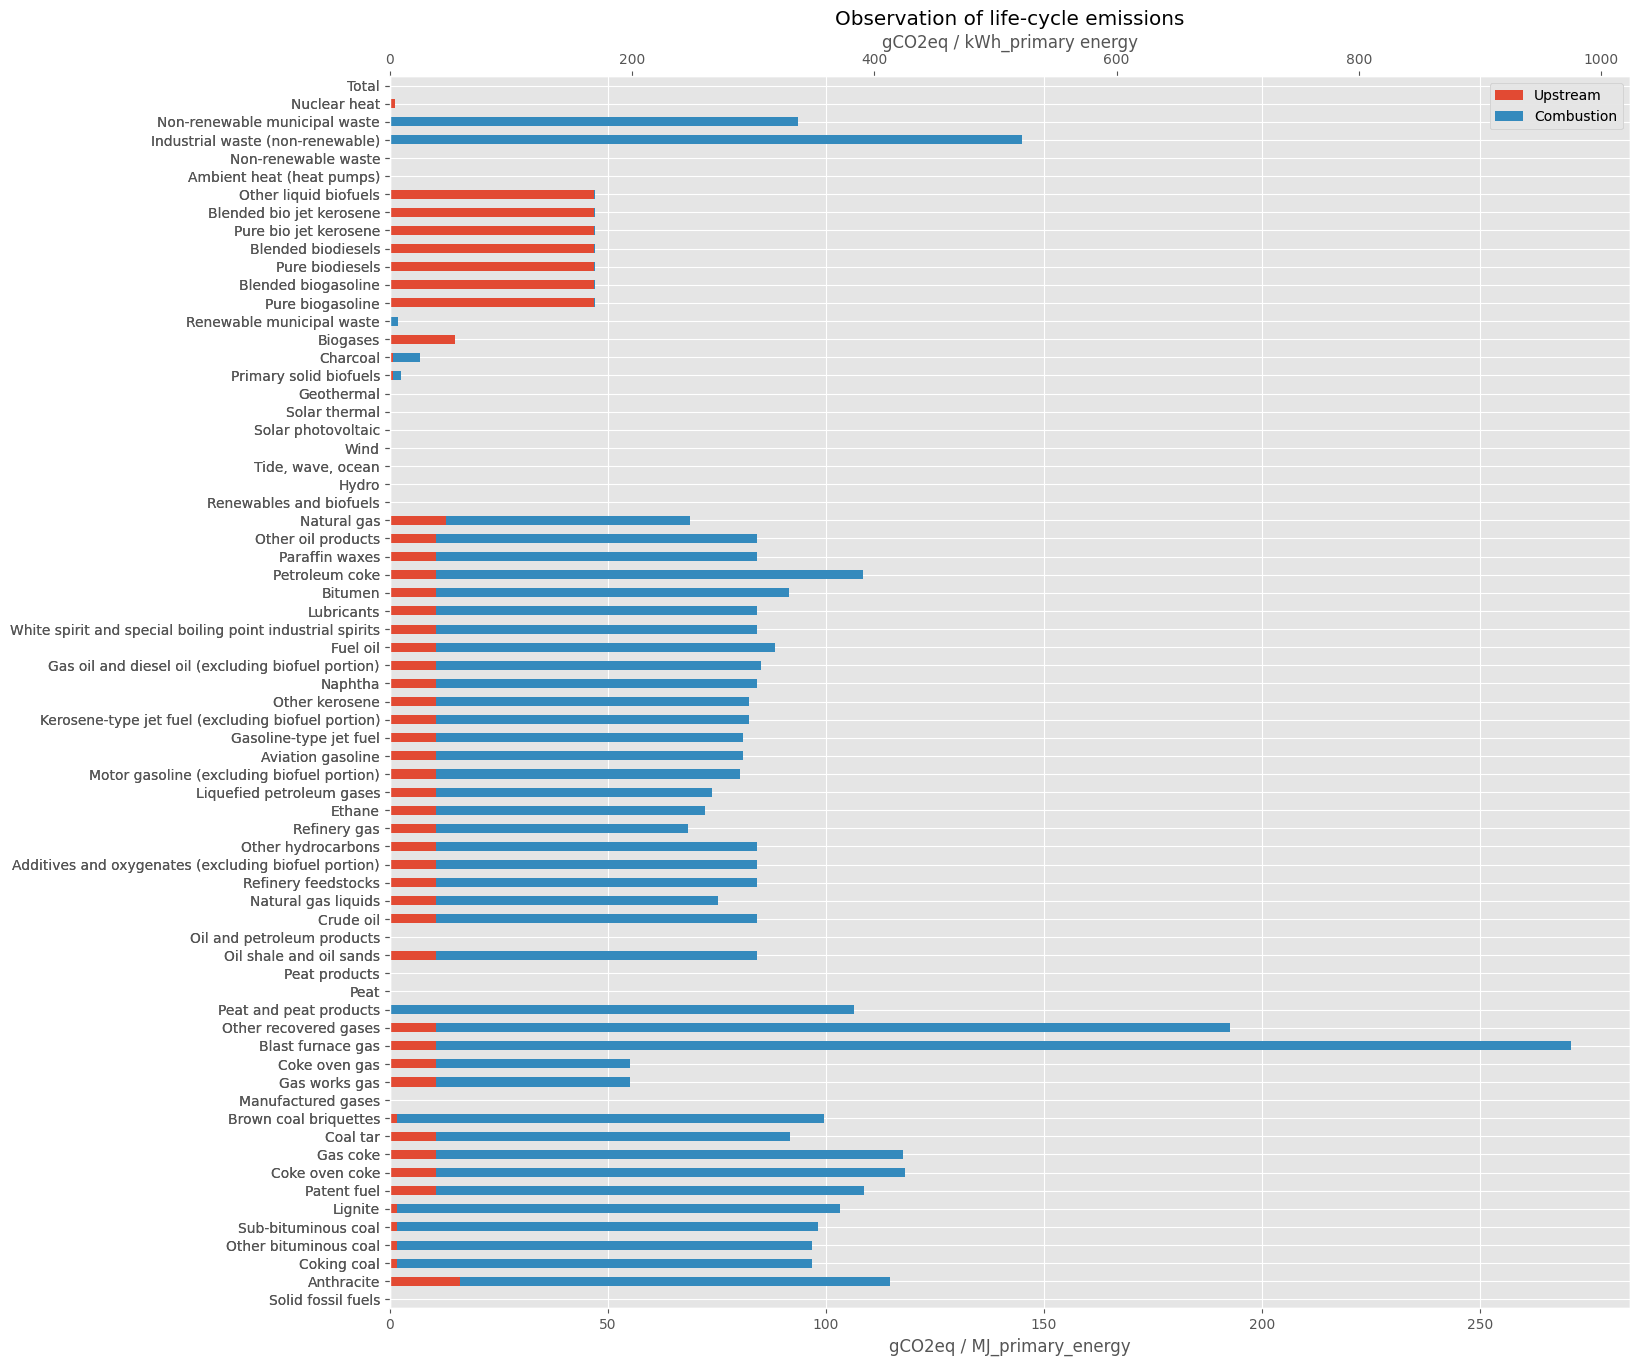

In [7]:
dfp = pd.DataFrame()
dfp["Upstream"] = df_fuels["kg CO2eq / TJ"]["UpstreamE3"]
dfp["Combustion"] = df_fuels["kg CO2eq / TJ (combustion)"]["Total"]

fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
(dfp * 1e3 / 1e6).plot(ax=ax, kind="barh", stacked=True)
(dfp / 1e6 * 3.6 * 1e3).plot(ax=ax2, kind="barh", stacked=True)
ax.set_title("Observation of life-cycle emissions")
ax.set_xlabel("gCO2eq / MJ_primary_energy")
ax2.set_xlabel("gCO2eq / kWh_primary energy")
ax2.grid(False)

# 2. Gross energy production per pathway for electricity production

https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_c/default/table?lang=en

## Data Formating

In [12]:
# Takes around 1 minute to run, need to be runned just once
if False:
    # Loading and formating file
    df = pd.read_csv("data/nrg_bal_c.tsv", sep="\t")
    df.columns = [col.strip() for col in df.columns]
    for i, col in enumerate("nrg_bal,siec,unit,geo\\time".split(",")):
        col = col.split("\\t")[0]
        # print(i, col)
        df[col] = df["nrg_bal,siec,unit,geo\\time"].apply(lambda x: x.split(",")[i])
    df = df.drop("nrg_bal,siec,unit,geo\\time", axis=1)
    df = df[df.unit == "TJ"]  # just keep data in TJ
    df = df.replace(": ", np.nan).replace(": z", np.nan)
    df = df.apply(pd.to_numeric, errors="ignore")
    df_eurostat = df.pivot_table(columns=["nrg_bal", "siec", "geo"])

    # Exported formated data in a pickle file
    df_eurostat.to_pickle("data/df_eurostat.pkl")

/tmp/ipykernel_94689/2607757242.py:14: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_eurostat = df.pivot_table(columns=["nrg_bal", "siec", "geo"])


In [15]:
# Getting dictionary of eurostat label for energy names and columns
df = pd.read_excel(
    "data/Energy-Balance-Formulas.xlsx",
    sheet_name="CODES CORRESPONDANCE",
    header=1,
    index_col=0,
)

dict_eurostat_energy_name = df.iloc[0:70][
    "New dissemination labels of Eurostat"
].to_dict()
dict_eurostat_energy_columns = df.iloc[77:-1][
    "New dissemination labels of Eurostat"
].to_dict()

dict_eurostat_energy_name_inv = {
    v.split(" (")[0]: k for k, v in dict_eurostat_energy_name.items()
}
dict_eurostat_energy_columns_inv = {
    v: k for k, v in dict_eurostat_energy_columns.items()
}

In [16]:
# List of useful columns
list_nrg_bal = [
    "GHP_APCHP",
    "GHP_MAPCHP",
    "TI_EHG_APCHP_E",
    "TI_EHG_APE_E",
    "TI_EHG_MAPCHP_E",
    "TI_EHG_MAPE_E",
]

# Printing matching full name
for nrg in list_nrg_bal:
    print(f"{nrg} : {dict_eurostat_energy_columns[nrg]}")

GHP_APCHP : Gross heat production - autoproducer combined heat and power
GHP_MAPCHP : Gross heat production - main activity producer combined heat and power
TI_EHG_APCHP_E : Transformation input - electricity and heat generation - autoproducer combined heat and power - energy use
TI_EHG_APE_E : Transformation input - electricity and heat generation - autoproducer electricity only - energy use
TI_EHG_MAPCHP_E : Transformation input - electricity and heat generation - main activity producer combined heat and power - energy use
TI_EHG_MAPE_E : Transformation input - electricity and heat generation - main activity producer electricity only - energy use


In [110]:
# Importing data
df_eurostat = pd.read_pickle("data/df_eurostat.pkl")

# Sum of main and autoproducer of electricity only
df_eurostat_electricity_only = df_eurostat["TI_EHG_MAPE_E"].add(
    df_eurostat["TI_EHG_APE_E"], axis=1, fill_value=0
)
# Difference of CHP energy use and heat generation assuming a 85% efficiency for main produceur
df_eurostat_CHP_main = df_eurostat["TI_EHG_MAPCHP_E"].sub(
    df_eurostat["GHP_MAPCHP"] / 0.85, fill_value=0
)
# Difference of CHP energy use and heat generation assuming a 85% efficiency for autoproduceur
df_eurostat_CHP_auto = df_eurostat["TI_EHG_APCHP_E"].sub(
    df_eurostat["GHP_APCHP"] / 0.85, fill_value=0
)
# Sum of main and CHP autoproduceur
df_eurostat_CHP = df_eurostat_CHP_main.add(df_eurostat_CHP_auto, fill_value=0)
# Sum of electricity only and CHP
df_Bi = df_eurostat_electricity_only.add(df_eurostat_CHP, fill_value=0)
df_Bi = df_Bi.T.unstack()
df_Bi["siec"] = df_Bi.index
df_Bi["siec"] = df_Bi.siec.replace(dict_eurostat_energy_name)
df_Bi.index = df_Bi.siec
df_Bi = df_Bi.drop("siec", axis=1)
df_Bi.to_pickle("data/df_Bi.pkl")

In [111]:
df_eurostat_electricity_only_input = df_eurostat["TI_EHG_MAPE_E"].add(
    df_eurostat["TI_EHG_APE_E"], axis=1, fill_value=0
)
df_eurostat_electricity_only_output = df_eurostat["GEP_MAPE"].add(
    df_eurostat["GEP_APE"], axis=1, fill_value=0
)
df_eurostat_efficiency_gross = df_eurostat_electricity_only_output.divide(df_eurostat_electricity_only_input)
#fig, ax = plt.subplots(figsize=(16, 16))
#df_eurostat_electricity_only_output.T.unstack()['2019']["EU27_2020"].plot(ax = ax, kind="barh")

<AxesSubplot: ylabel='siec'>

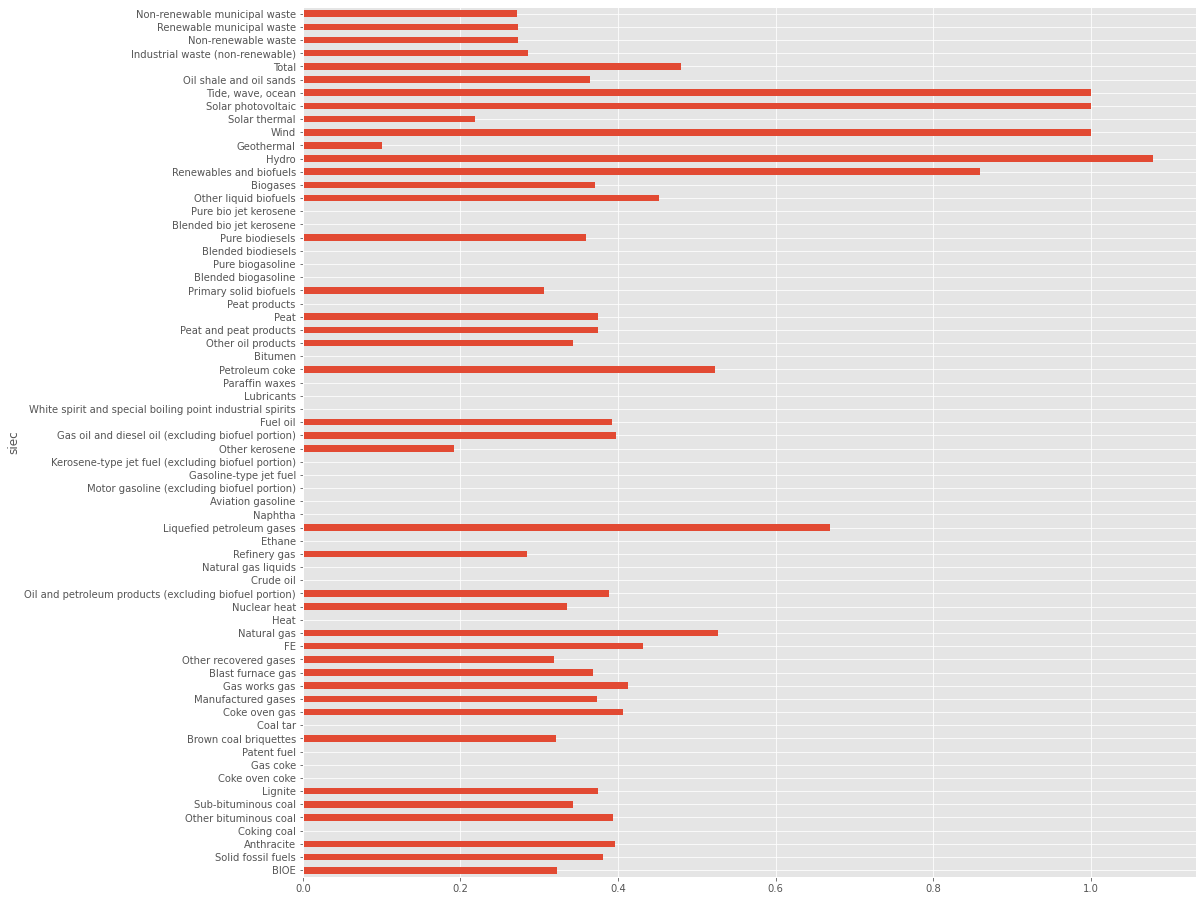

In [150]:
fig, ax = plt.subplots(figsize=(16, 16))
df_eurostat_efficiency_gross_T = df_eurostat_efficiency_gross.T.unstack()
df_eurostat_efficiency_gross_T["siec"] = df_eurostat_efficiency_gross_T.index
df_eurostat_efficiency_gross_T["siec"] = df_eurostat_efficiency_gross_T.siec.replace(dict_eurostat_energy_name)
df_eurostat_efficiency_gross_T.index = df_eurostat_efficiency_gross_T.siec
df_eurostat_efficiency_gross_T = df_eurostat_efficiency_gross_T.drop("siec", axis=1)
df_eurostat_efficiency_gross_T['2019']["EU27_2020"].plot(ax = ax, kind="barh")

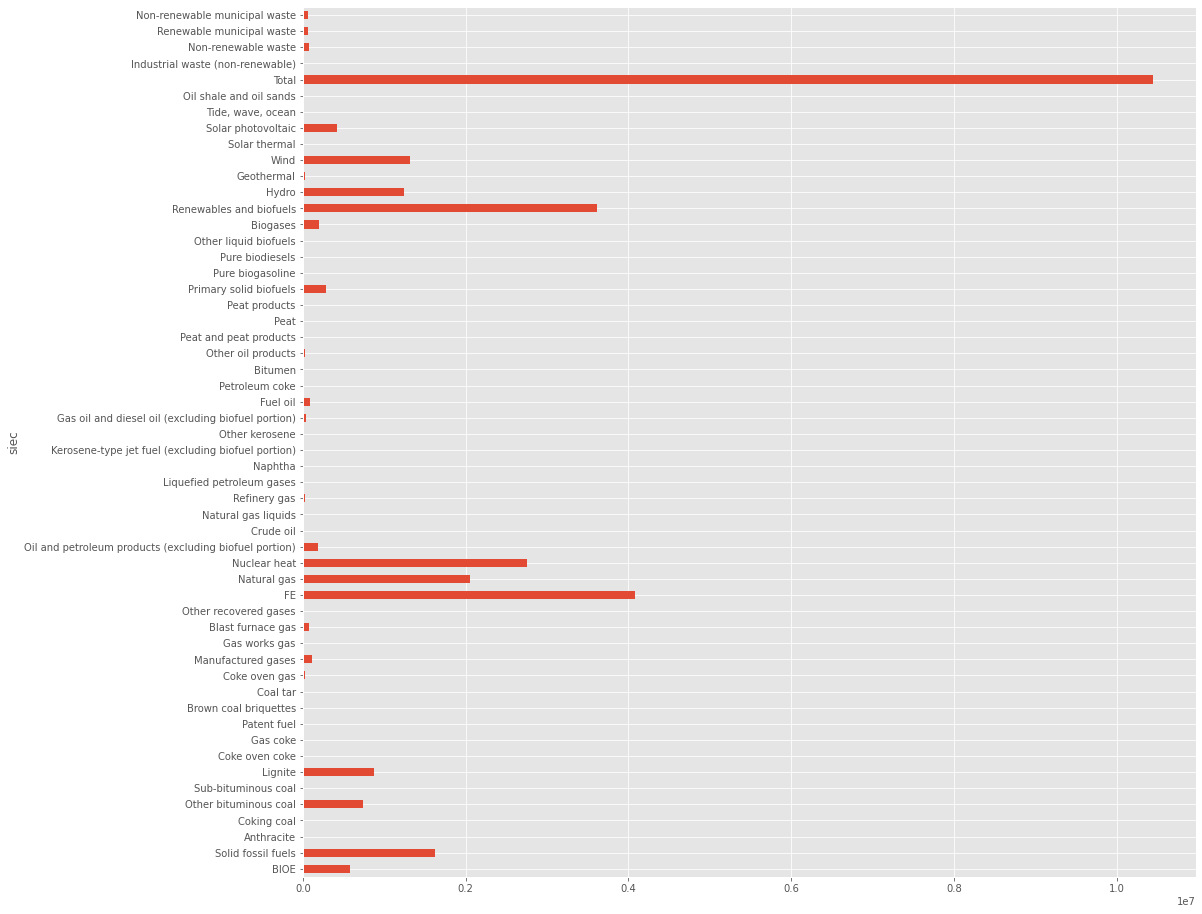

In [156]:
fig, ax = plt.subplots(figsize=(16, 16))
df_gep = df_eurostat["GEP"].T.unstack()
df_gep["siec"] = df_gep.index
df_gep["siec"] = df_gep.siec.replace(dict_eurostat_energy_name)
df_gep.index = df_gep.siec
df_gep = df_gep.drop("siec", axis=1)
df_gep['2019']["EU27_2020"].plot(ax = ax, kind="barh")
#.divide(df_eurostat_efficiency_gross)
df_Bi_efficiency = df_Bi_efficiency.T.unstack()
df_Bi_efficiency["siec"] = df_Bi_efficiency.index
df_Bi_efficiency["siec"] = df_Bi_efficiency.siec.replace(dict_eurostat_energy_name)
df_Bi_efficiency.index = df_Bi_efficiency.siec
df_Bi_efficiency = df_Bi_efficiency.drop("siec", axis=1)

#df_Bi_efficiency['2019']["EU27_2020"].plot(ax = ax, kind="barh")

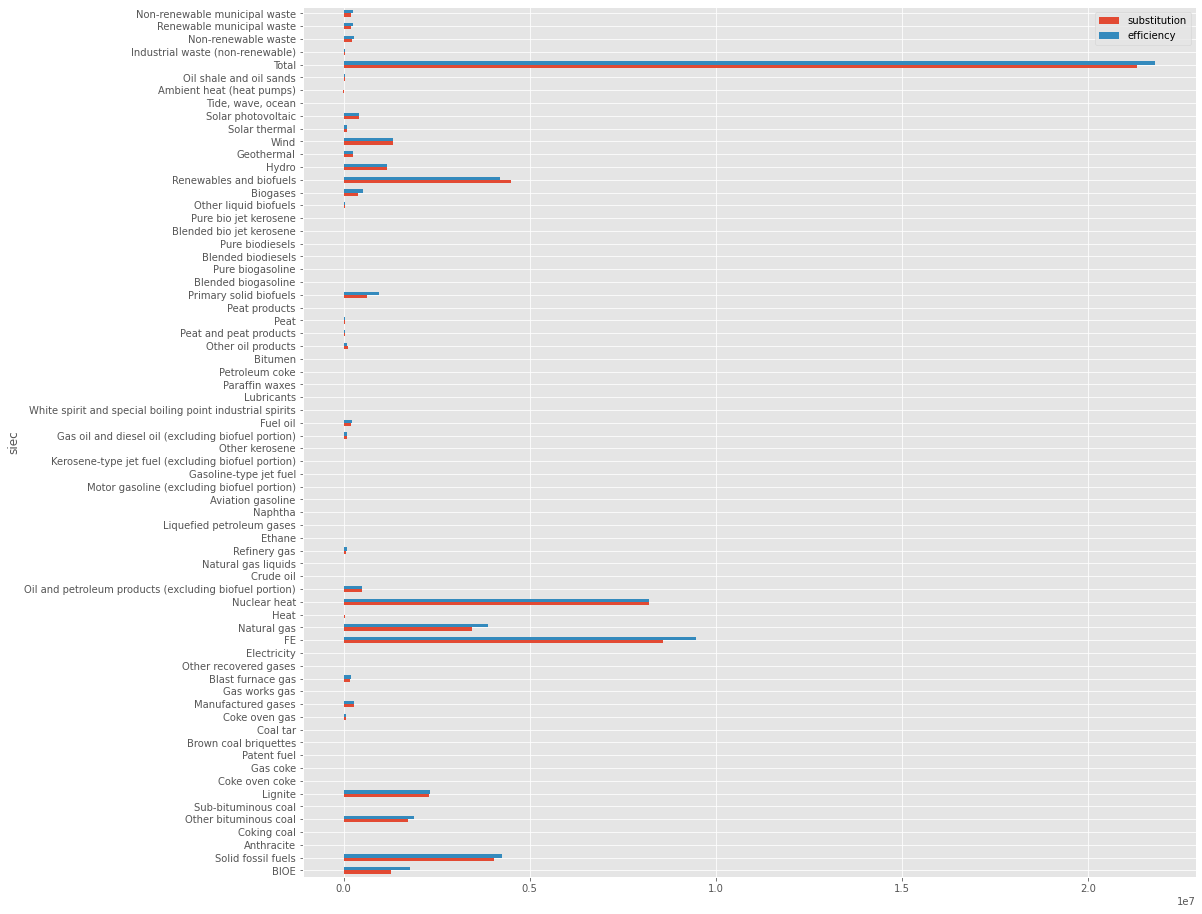

In [134]:
df_temp = pd.concat([df_Bi["2019"]["EU27_2020"], df_Bi_efficiency["2019"]["EU27_2020"]], keys=["substitution", "efficiency"], axis=1)
fig, ax = plt.subplots(figsize=(16, 16))
df_temp.plot(ax=ax, kind="barh")
plt.savefig('foo.png')
df_temp["% diff"] = abs((df_temp["substitution"] - df_temp["efficiency"]) / df_temp["efficiency"])


<AxesSubplot: ylabel='siec'>

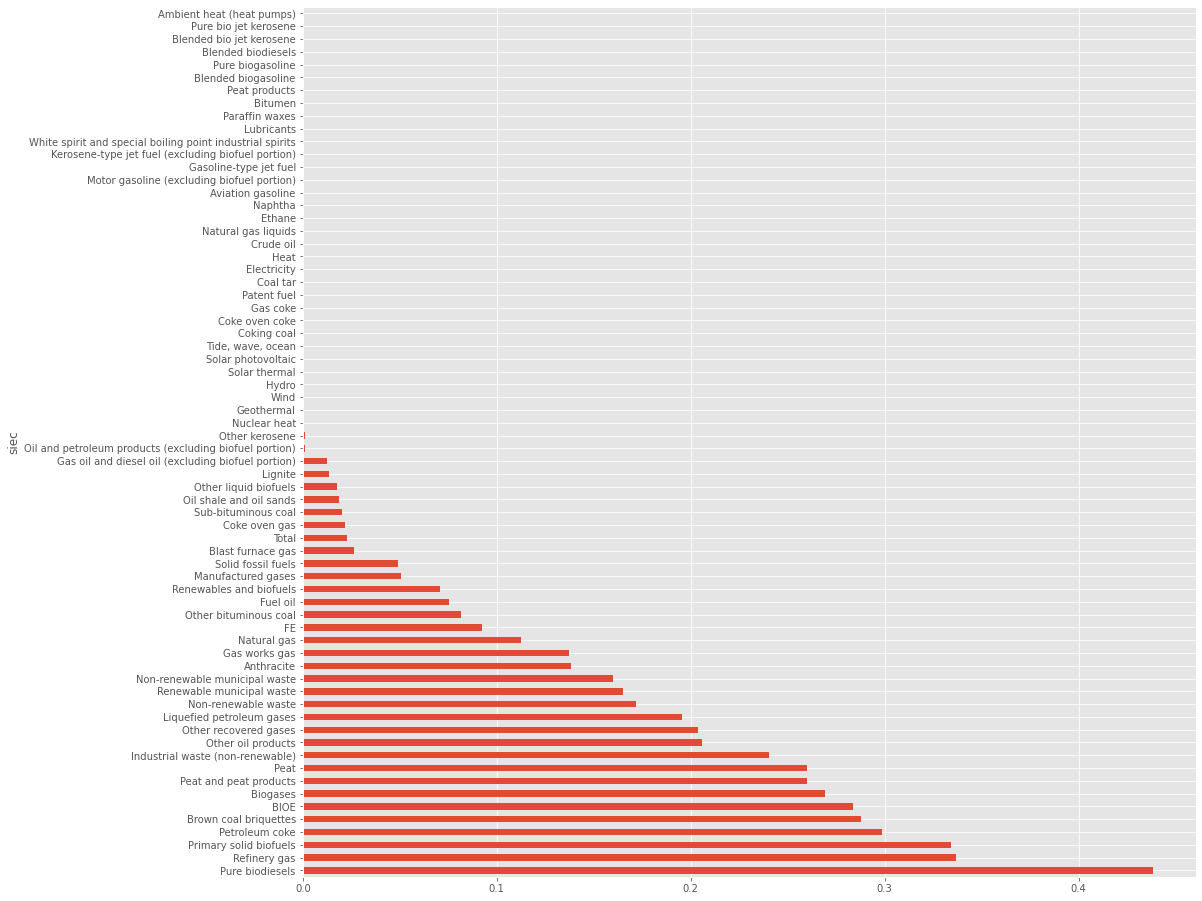

In [137]:
fig, ax = plt.subplots(figsize=(16, 16))
df_temp['% diff'].sort_values(ascending=False).plot(kind="barh")

## Data observation

In [160]:
df_Bi = pd.read_pickle("data/df_Bi.pkl")

Text(0.5, 1.0, 'Gross primary energy for electricity production')

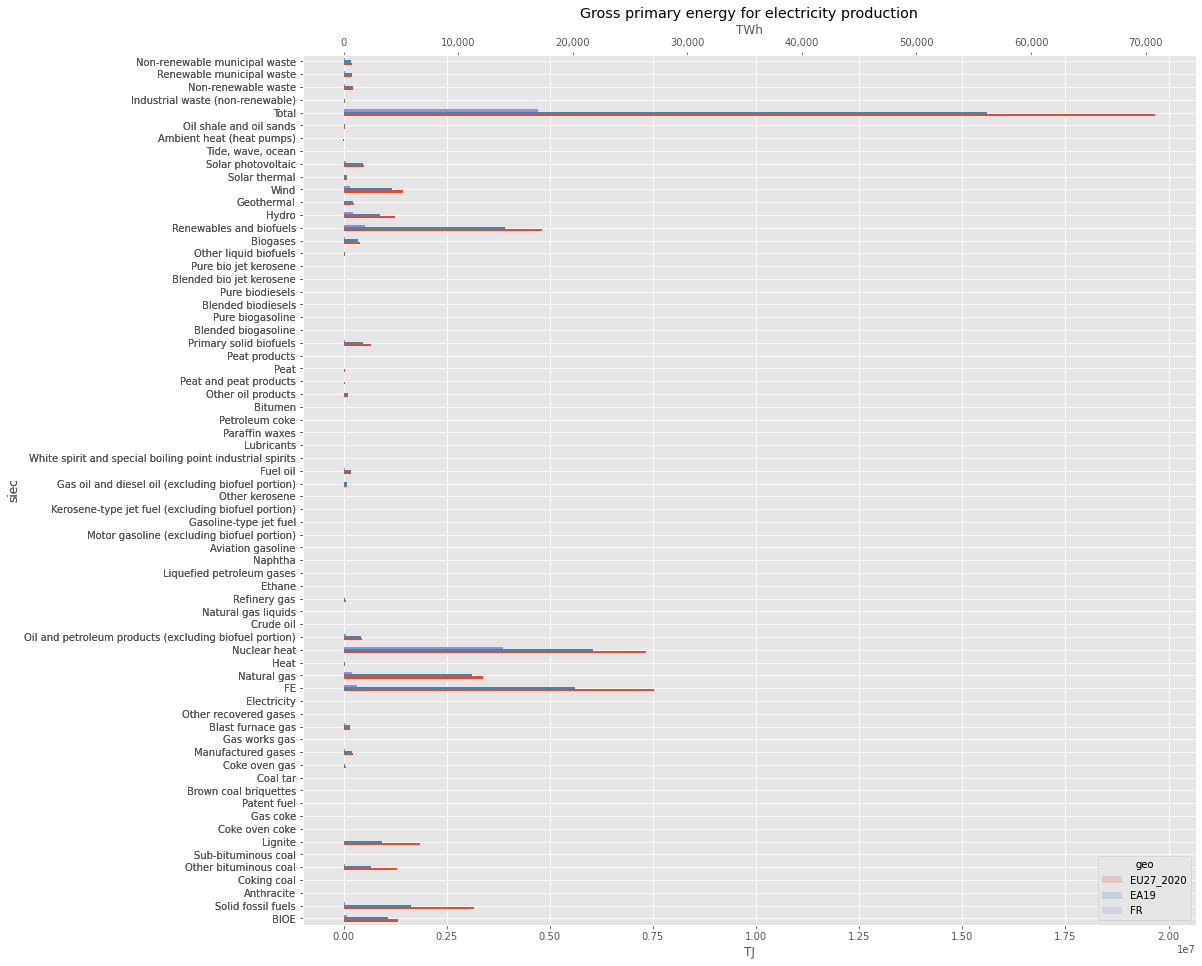

In [161]:
fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
df_Bi["2020"][["EU27_2020", "EA19", "FR"]].plot(ax=ax, kind="barh")
(df_Bi["2020"][["EU27_2020", "EA19", "FR"]] * 1e6 * 3.6 * 1e-9).plot(
    ax=ax2, kind="barh", alpha=0
)
ax.set_xlabel("TJ")
ax2.set_xlabel("TWh")
ax2.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax2.grid(False)
ax.set_title("Gross primary energy for electricity production")

# 3. Greenhouse gas emissions for the total gross energy production of electricity production

## Data calculation

In [163]:
# Contains the emission per unit of energy for every pathway
df_fuels = pd.read_pickle("data/df_fuels.pkl")
# Contains the amount of energy for every pathway
df_Bi = pd.read_pickle("data/df_Bi.pkl")
#df_Bi = df_Bi_efficiency
#display(df_Bi)
# Formating dataframes to multiply them using index and columns names
df_Bi.index = [index.split(" (")[0] for index in df_Bi.index]
df_fuels.index = [index.split(" (")[0] for index in df_fuels.index]

common_index = df_Bi.drop(
    ["BIOE", "FE", "Heat", "Electricity"] #"Electricity", 
).index  # those value do not have emissions factors as they are agregate of categories having emission factors
df_Bi = df_Bi.loc[common_index]
df_fuels = df_fuels.loc[common_index]

# Calculation of greenhouse gas emissions for the energy production of the electricity production
df_GHG_upstream = df_Bi.replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ"]["UpstreamE3"].dropna(), axis=0
)
df_GHG_combustion = df_Bi.replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ (combustion)"].Total, axis=0
)
df_GHG = df_GHG_upstream.add(df_GHG_combustion, fill_value=0)
df_GHG = df_GHG.stack().T
df_GHG = df_GHG.swaplevel(0, 1, axis=1)
df_GHG.to_pickle("data/df_GHG.pkl")
df_GHG_upstream.stack().T.swaplevel(0, 1, axis=1).to_pickle("data/df_GHG_upstream.pkl")
df_GHG_combustion.stack().T.swaplevel(0, 1, axis=1).to_pickle(
    "data/df_GHG_combustion.pkl"
)

In [139]:
# Correspondance between country code and country name
import pycountry

list_country = df_GHG.columns.get_level_values(0).unique()
list_country = [
    country for country in list_country if country not in ["EU27_2020", "EA19"]
]

dict_countries = {}

for country_code in list_country:
    # print(country_code)
    if country_code == "FRM":
        country_name = "France Metropolitaine"
    if country_code == "EL":
        country_name = "Greece"
    elif country_code == "UK":
        country_name = "United Kingdom"
    elif country_code == "XK":
        country_name = "Kosovo"
    else:
        COUNTRY = pycountry.countries.get(alpha_2=country_code)
        country_name = COUNTRY.name
    # print(f"{country_code}:{country_name}")
    dict_countries[country_code] = country_name
dict_countries["EU27_2020"] = "European Union - 27 countries (from 2020)"
dict_countries["EA19"] = "Euro area - 19 countries (2015-2022)"

## Data observation

Text(0.5, 1.0, 'GHG emissions of gross energy production for electricity production: upstream part')

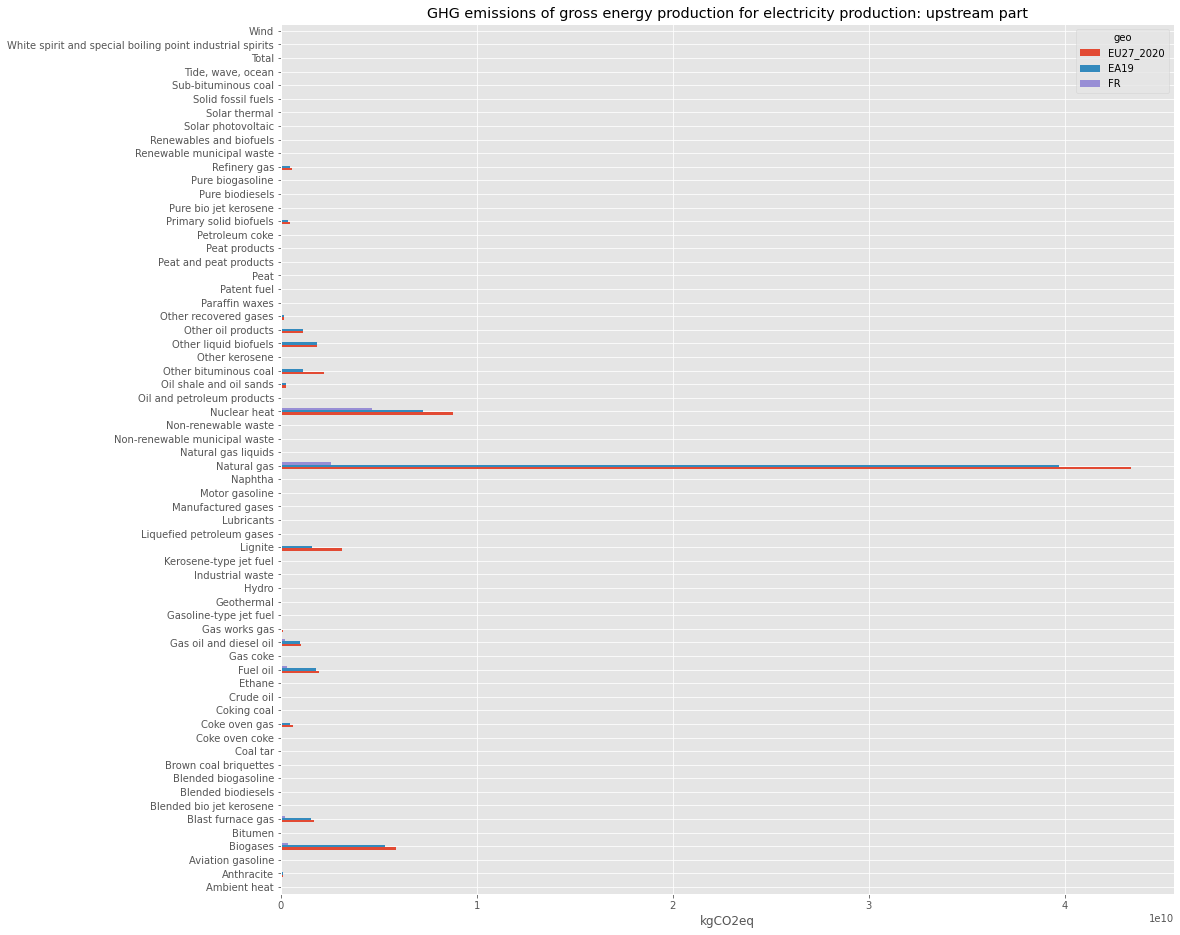

In [164]:
fig, ax = plt.subplots(figsize=(16, 16))
df_GHG_upstream["2020"][["EU27_2020", "EA19", "FR"]].plot(ax=ax, kind="barh")
ax.set_xlabel("kgCO2eq")
ax.set_title(
    "GHG emissions of gross energy production for electricity production: upstream part"
)

Text(0.5, 1.0, 'GHG emissions of gross energy production for electricity production: combustion part')

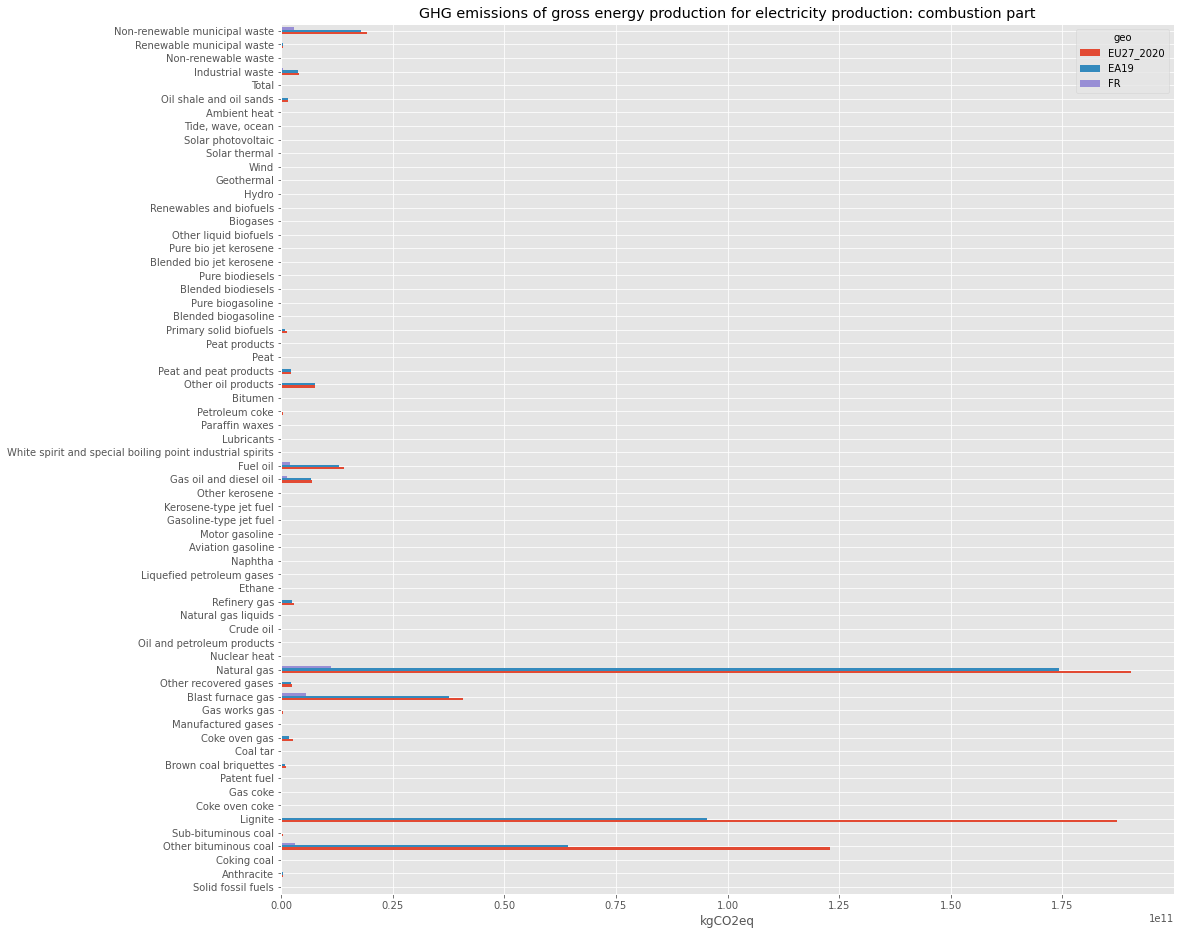

In [165]:
fig, ax = plt.subplots(figsize=(16, 16))
df_GHG_combustion["2020"][["EU27_2020", "EA19", "FR"]].plot(ax=ax, kind="barh")
ax.set_xlabel("kgCO2eq")
ax.set_title(
    "GHG emissions of gross energy production for electricity production: combustion part"
)

,Ambient heat,Anthracite,Aviation gasoline,Biogases,Bitumen,Blast furnace gas,Blended bio jet kerosene,Blended biodiesels,Blended biogasoline,Brown coal briquettes,...,Renewable municipal waste,Renewables and biofuels,Solar photovoltaic,Solar thermal,Solid fossil fuels,Sub-bituminous coal,"Tide, wave, ocean",Total,White spirit and special boiling point industrial spirits,Wind
1990,0.0,0.000000e+00,0.0,1.230323e+08,0.000000e+00,4.911126e+10,0.0,0.000000e+00,0.0,4.339023e+09,...,6.195220e+07,0.0,0.0,0.0,0.0,7.279988e+09,0.0,0.0,0.0,0.0
1991,0.0,0.000000e+00,0.0,1.285796e+08,0.000000e+00,4.993214e+10,0.0,0.000000e+00,0.0,1.928270e+09,...,6.384713e+07,0.0,0.0,0.0,0.0,1.014076e+10,0.0,0.0,0.0,0.0
1992,0.0,0.000000e+00,0.0,2.010734e+08,0.000000e+00,4.877837e+10,0.0,0.000000e+00,0.0,3.975854e+09,...,6.639207e+07,0.0,0.0,0.0,0.0,1.018418e+10,0.0,0.0,0.0,0.0
1993,0.0,0.000000e+00,0.0,2.322261e+08,0.000000e+00,4.975185e+10,0.0,0.000000e+00,0.0,2.110610e+09,...,6.845836e+07,0.0,0.0,0.0,0.0,1.080723e+10,0.0,0.0,0.0,0.0
1994,0.0,0.000000e+00,0.0,2.491118e+08,0.000000e+00,5.008441e+10,0.0,0.000000e+00,0.0,2.398277e+09,...,7.159708e+07,0.0,0.0,0.0,0.0,1.090785e+10,0.0,0.0,0.0,0.0
1995,0.0,0.000000e+00,0.0,2.922713e+08,2.628191e+09,5.138866e+10,0.0,0.000000e+00,0.0,1.900276e+09,...,9.147745e+07,0.0,0.0,0.0,0.0,1.110281e+10,0.0,0.0,0.0,0.0
1996,0.0,0.000000e+00,0.0,3.275884e+08,4.701404e+09,4.894255e+10,0.0,0.000000e+00,0.0,1.291308e+09,...,1.027098e+08,0.0,0.0,0.0,0.0,1.025698e+10,0.0,0.0,0.0,0.0
1997,0.0,0.000000e+00,0.0,4.001201e+08,5.398352e+09,5.515658e+10,0.0,0.000000e+00,0.0,1.157044e+09,...,1.106685e+08,0.0,0.0,0.0,0.0,8.932823e+09,0.0,0.0,0.0,0.0
1998,0.0,0.000000e+00,0.0,4.181432e+08,4.376594e+09,5.603696e+10,0.0,0.000000e+00,0.0,1.218197e+09,...,1.209097e+08,0.0,0.0,0.0,0.0,6.599983e+09,0.0,0.0,0.0,0.0
1999,0.0,0.000000e+00,0.0,4.261731e+08,4.511669e+09,5.668045e+10,0.0,0.000000e+00,0.0,1.395213e+09,...,1.329531e+08,0.0,0.0,0.0,0.0,5.799079e+09,0.0,0.0,0.0,0.0


/tmp/ipykernel_94689/185131058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)
/tmp/ipykernel_94689/185131058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)


Text(0.5, 1.0, 'GHG emissions of gross energy production for electricity production: upstream + combustion part')

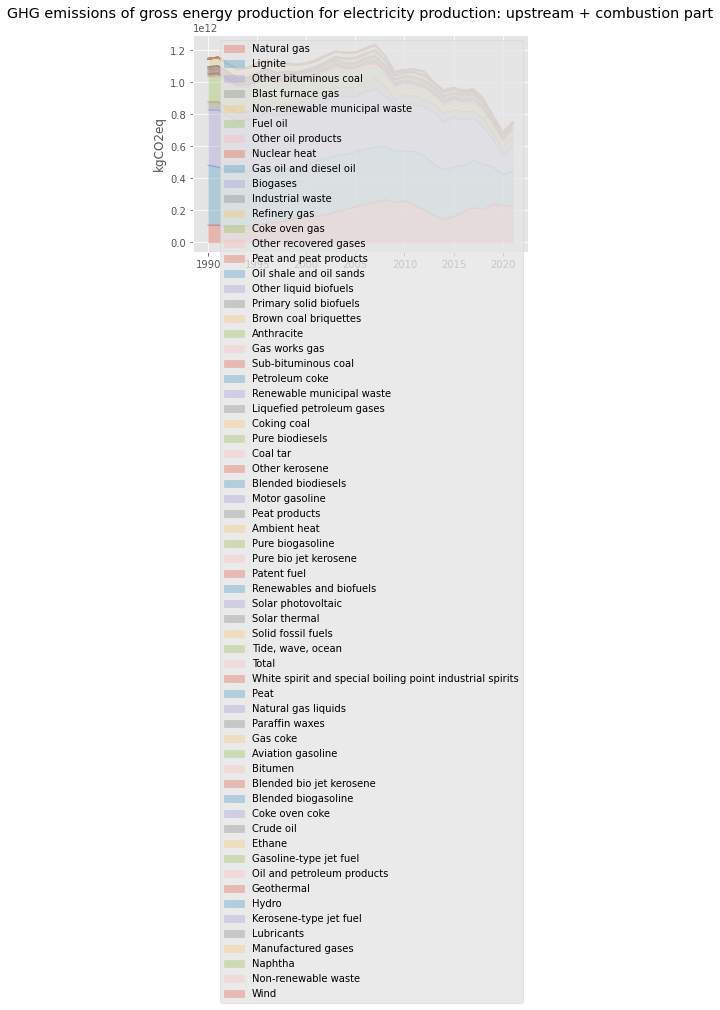

In [168]:
fig, ax = plt.subplots()
df = df_GHG["EU27_2020"]
display(df)
df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)
df = df.sort_values("2020", axis=1, ascending=False)
df.plot(ax=ax, kind="area", alpha=0.3)
ax.set_ylabel("kgCO2eq")
ax.set_title(
    "GHG emissions of gross energy production for electricity production: upstream + combustion part"
)

<AxesSubplot: >

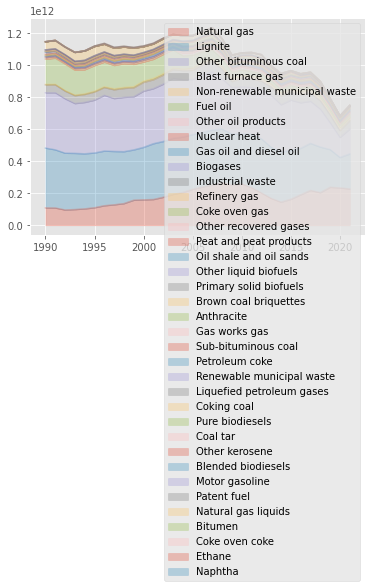

In [174]:

fig, ax = plt.subplots()
df = df.loc[:, df.sum() > 1]
df = df.sort_values("2020", axis=1, ascending=False)
df.plot(ax=ax, kind="area", alpha=0.3)

# 4. Net electricity production

## Data calculation

In [141]:
# List of useful columns
list_nrg_bal = [
    "TI_EHG_EPS",
    "TO_EHG_PH",
    "NRG_EHG_E",
    "GEP",
    "TO_EHG",
]

# Printing matching full name
for nrg in list_nrg_bal:
    print(f"{nrg}: {dict_eurostat_energy_columns[nrg]}")

TI_EHG_EPS: Transformation input - electricity and heat generation - electricity for pumped storage
TO_EHG_PH: Transformation output - electricity and heat generation - pumped hydro
NRG_EHG_E: Energy sector - electricity and heat generation - energy use
GEP: Gross electricity production
TO_EHG: Transformation output - electricity and heat generation


In [142]:
# Importing data
df_eurostat = pd.read_pickle("data/df_eurostat.pkl")
df_eurostat = df_eurostat.replace(np.nan, 0)
df_eurostat_E_pump = +df_eurostat[
    "TI_EHG_EPS"
]  # no need to substract TO_EHG_PH as it is already included in the gross electricity production (GEP) or TO_EHG
df_eurostat_E_own = df_eurostat["NRG_EHG_E"]
# Taking only electricity columns (E7000) instead of total
df_eurostat_E_own_without_total = df_eurostat_E_own.drop("TOTAL", axis=1, level=0)
df_eurostat_E_own_total = pd.concat(
    [df_eurostat_E_own["E7000"]], axis=1, keys=["TOTAL"]
)
df_eurostat_E_own = pd.concat(
    [df_eurostat_E_own_without_total, df_eurostat_E_own_total], axis=1
)
df_eurostat_E_gross = df_eurostat["GEP"]  # also correspond to TO_EHG
df_eurostat_E_net = df_eurostat_E_gross.sub(df_eurostat_E_own, fill_value=0).sub(
    df_eurostat_E_pump, fill_value=0
)
df_eurostat_E_net = df_eurostat_E_net.replace(np.nan, 0)
df_eurostat_E_net = df_eurostat_E_net.rename(columns=dict_eurostat_energy_name)
# df_eurostat_E_net = df_eurostat_E_net.swaplevel(0, 1, axis=1)
# df_eurostat_E_net = df_eurostat_E_net.rename(columns=dict_countries)
df_eurostat_E_net.to_pickle("data/df_eurostat_E_net.pkl")

## Data observation

In [21]:
df_eurostat_E_net = pd.read_pickle("data/df_eurostat_E_net.pkl")
df_eurostat_E_net.head()

siec BIOE                                                                      \
geo    AL        AT   BA        BE      BG   CY        CZ        DE        DK   
1990  0.0  3783.827  0.0   950.972   0.000  0.0     0.000  5257.461   628.843   
1991  0.0  4048.918  0.0  1004.561   0.000  0.0     0.000  6186.960   986.974   
1992  0.0  4376.637  0.0   895.390  -8.079  0.0     0.000  6755.189  1380.599   
1993  0.0  4589.322  0.0   822.879 -11.787  0.0   538.149  6493.577  1845.317   
1994  0.0  4056.319  0.0   823.712 -13.873  0.0  1071.191  6832.711  1747.319   

siec             ... Non-renewable municipal waste                             \
geo        EA19  ...                            PT   RO   RS     SE   SI   SK   
1990  39046.252  ...                           0.0  0.0  0.0  223.2  0.0  0.0   
1991  41243.167  ...                           0.0  0.0  0.0  219.6  0.0  0.0   
1992  42225.196  ...                           0.0  0.0  0.0  226.8  0.0  0.0   
1993  45628.728  ...                           0.0  0.0  0.0  234.0  0.0  0.0   
1994  48428.824  ...                           0.0  0.0  0.0  194.4  0.0  0.0   

siec                         
geo    TR   UA      UK   XK  
1990  0.0  0.0   298.8  0.0  
1991  0.0  0.0   316.8  0.0  
1992  0.0  0.0   374.4  0.0  
1993  0.0  0.0   597.6  0.0  
1994  0.0  0.0  1263.6  0.0  

[5 rows x 2856 columns]

Text(0.5, 1.0, 'Net electricity production')

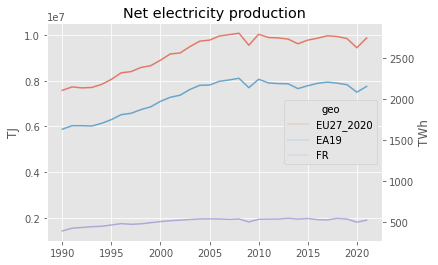

In [157]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_eurostat_E_net["Total"][["EU27_2020", "EA19", "FR"]].plot(
    ax=ax, kind="line", stacked=False, alpha=0.7
)
(df_eurostat_E_net["Total"][["EU27_2020", "EA19", "FR"]] * 1e6 / 3.6 / 1e9).plot(
    ax=ax2, kind="line", stacked=False, alpha=0
)
ax.set_ylabel("TJ")
ax2.set_ylabel("TWh")
ax2.grid(False)
ax.set_title("Net electricity production")

# 5. Carbon intensity of electricity production

In [76]:
df_GHG = pd.read_pickle("data/df_GHG.pkl")
df_eurostat_E_net.to_pickle("data/df_eurostat_E_net.pkl")

In [77]:
df_CI = df_GHG.sum(level=0, axis=1).divide(df_eurostat_E_net.Total, axis=0)
df_CI.to_pickle("data/df_CI.pkl")

/tmp/ipykernel_94689/1598807666.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_CI = df_GHG.sum(level=0, axis=1).divide(df_eurostat_E_net.Total, axis=0)


## Data observation

In [78]:
df_CI = pd.read_pickle("data/df_CI.pkl")
df_CI['EU27_2020']

1990    151189.559128
1991    149281.978265
1992    144392.849051
1993    139594.480576
1994    138820.799503
1995    138486.896288
1996    135726.965242
1997    132284.324927
1998    130529.531672
1999    128444.402330
2000    126234.160809
2001    124288.403622
2002    127298.739631
2003    126655.744460
2004    122846.149003
2005    122323.178472
2006    122582.829428
2007    124211.305396
2008    116560.952294
2009    112255.361399
2010    108351.200468
2011    110077.938813
2012    108855.810476
2013    102390.435768
2014     99428.063124
2015     99630.544561
2016     96834.103883
2017     96742.308597
2018     91256.695835
2019     81194.939168
2020     73045.748530
2021     76567.917185
Name: EU27_2020, dtype: float64

In [148]:
year = '2019'
df_GHG_upstream = df_Bi_efficiency[(year, "EU27_2020")].replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ"]["UpstreamE3"].dropna(), axis=0
)
df_GHG_combustion = df_fuels["kg CO2eq / TJ (combustion)"].multiply(
    df_Bi_efficiency[(year, "EU27_2020")].replace(np.nan, 0), axis=0
)
df_GHG_combustion["UpstreamE3"] = df_GHG_upstream
df_GHG_combustion.fillna(0).sum(axis=0).divide(df_eurostat_E_net.Total["EU27_2020"][year])

label
CO2           76325.060087
CH4             136.182195
N2O             391.293968
Total         76852.536250
UpstreamE3     8677.291605
dtype: float64

In [149]:
year = '2019'
df_GHG_upstream = df_Bi[(year, "EU27_2020")].replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ"]["UpstreamE3"].dropna(), axis=0
)
df_GHG_combustion = df_fuels["kg CO2eq / TJ (combustion)"].multiply(
    df_Bi[(year, "EU27_2020")].replace(np.nan, 0), axis=0
)
df_GHG_combustion["UpstreamE3"] = df_GHG_upstream
df_GHG_combustion.fillna(0).sum(axis=0).divide(df_eurostat_E_net.Total["EU27_2020"][year])

label
CO2           77561.827361
CH4             139.707904
N2O             397.460138
Total         78098.995402
UpstreamE3     8778.303215
dtype: float64

In [64]:
df_eurostat_E_net.Total["EU27_2020"]["2019"]

9850378.703999998

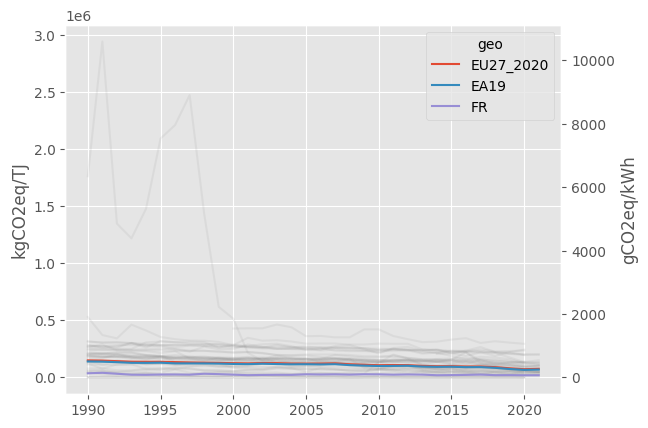

In [26]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_CI.plot(ax=ax, color="gray", alpha=0.1, legend=False)
(df_CI * 1e3 / 1e6 * 3.6).plot(ax=ax2, alpha=0, legend=False)
df_CI[["EU27_2020", "EA19", "FR"]].plot(ax=ax)
ax.set_ylabel("kgCO2eq/TJ")
ax2.set_ylabel("gCO2eq/kWh")
ax2.grid(False)

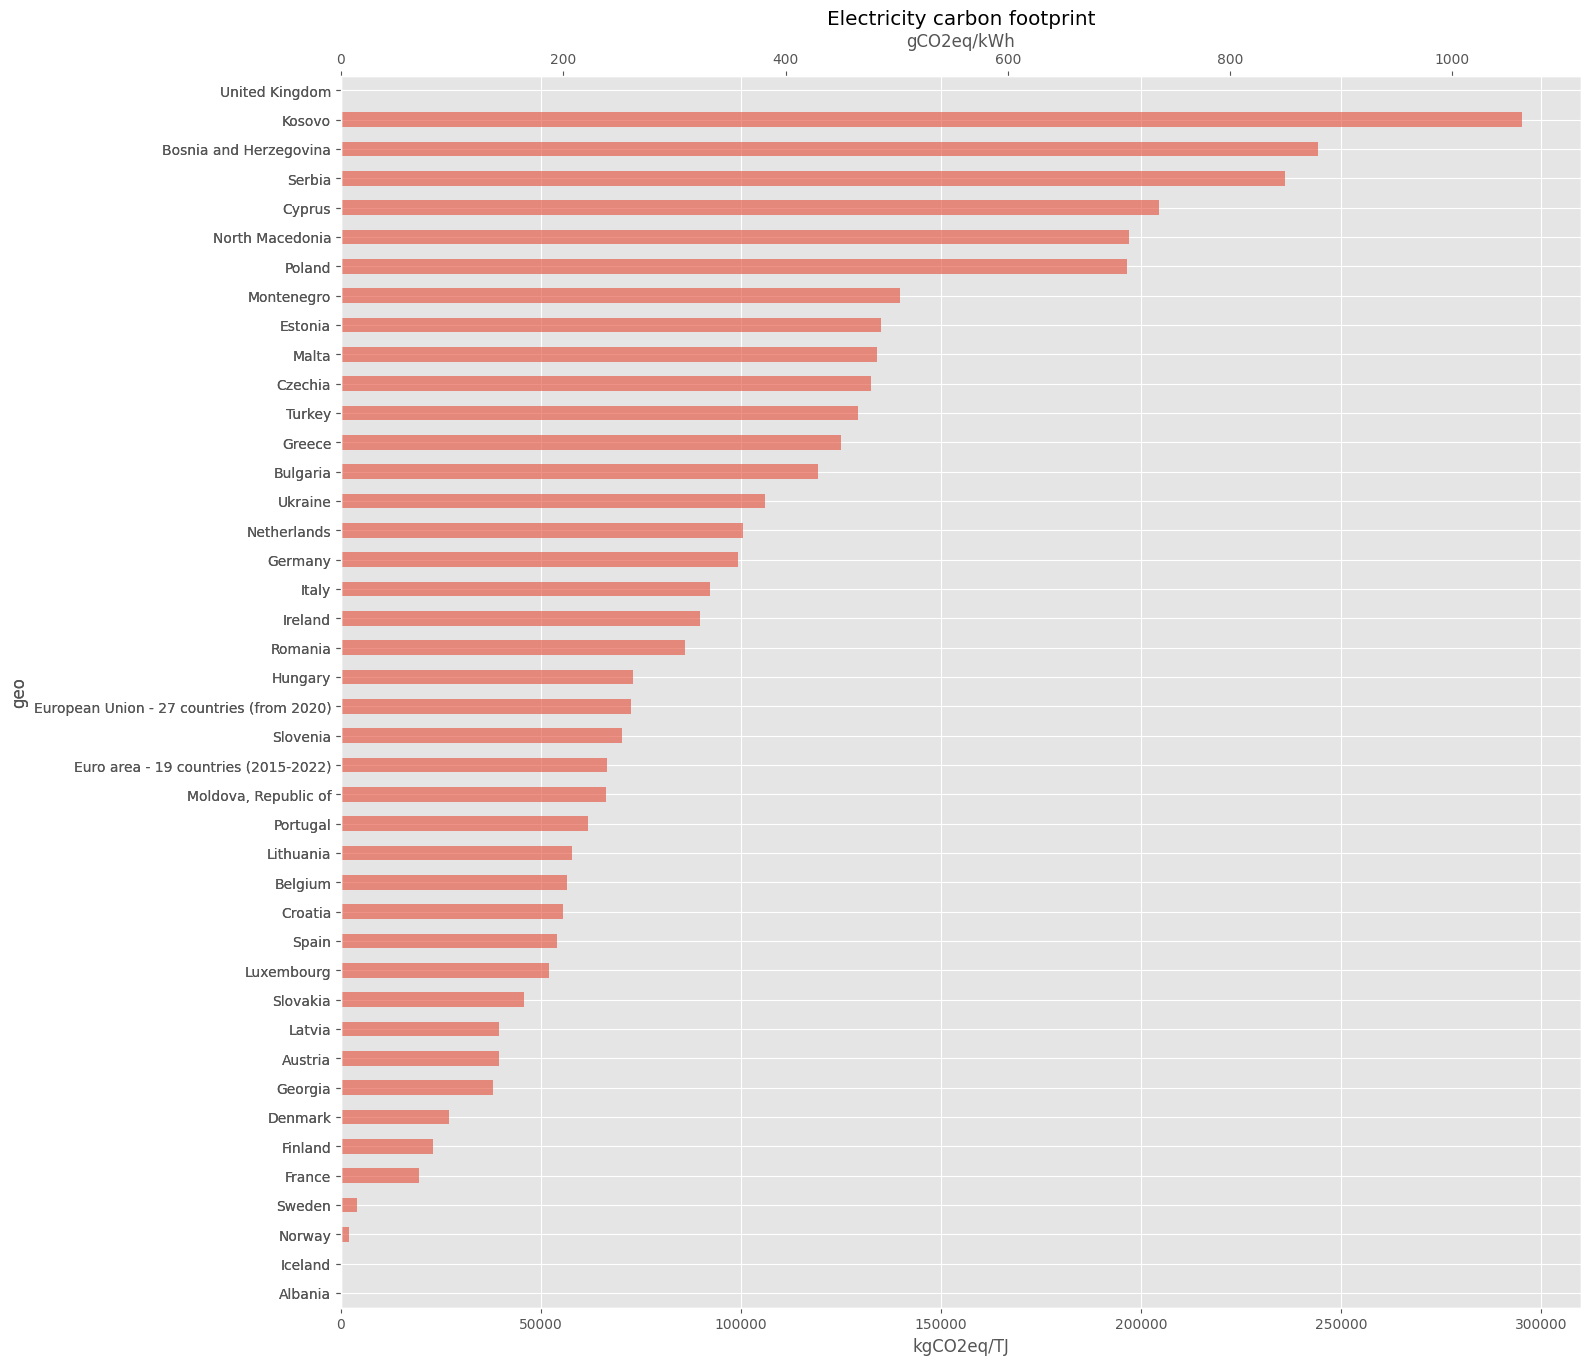

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
df_CI.T.rename(dict_countries).T.loc["2020"].sort_values().plot(
    ax=ax, kind="barh", alpha=0.6
)
(df_CI.T.rename(dict_countries).T.loc["2020"].sort_values() * 1e3 / 1e6 * 3.6).plot(
    ax=ax2, kind="barh", alpha=0
)
ax.set_title("Electricity carbon footprint")
ax.set_xlabel("kgCO2eq/TJ")
ax2.set_xlabel("gCO2eq/kWh")
ax2.grid(False)

# 6. Final interactive visualisation

In [28]:
import bokeh.plotting
import bokeh.models
import bokeh.palettes

In [29]:
df_CI = pd.read_pickle("data/df_CI.pkl")
dfp = df_CI.T.rename(dict_countries).T * 1e3 / 1e6
dfp.index = pd.to_datetime(dfp.index, format="%Y")
dfp.head()

geo,Albania,Austria,Bosnia and Herzegovina,Belgium,Bulgaria,Cyprus,Czechia,Germany,Denmark,Euro area - 19 countries (2015-2022),...,Portugal,Romania,Serbia,Sweden,Slovenia,Slovakia,Turkey,Ukraine,United Kingdom,Kosovo
1990-01-01,47.996585,78.228754,NaN,114.109750,204.702706,277.867428,246.494781,199.111662,204.987469,140.466988,...,165.024324,268.221004,287.408824,4.936592,140.190280,137.071356,190.083839,221.282425,214.371346,NaN
1991-01-01,26.037834,80.148696,NaN,112.589000,207.017995,273.770250,244.357777,202.369663,210.446954,138.513478,...,167.317946,289.190125,260.943459,7.263701,111.897683,141.180323,183.869666,210.133683,209.511962,NaN
1992-01-01,16.456285,63.704532,NaN,109.281969,224.087660,284.056176,243.023583,191.659325,201.739063,133.996264,...,203.022277,236.850712,273.477760,7.050344,131.342224,132.837458,180.317447,212.949799,206.679501,NaN
1993-01-01,27.675030,59.311508,NaN,113.926054,219.333696,282.997426,244.281928,191.593033,190.769796,128.480886,...,174.695877,231.985764,300.206162,7.546149,137.974772,134.492572,162.126177,215.606742,183.682379,NaN
1994-01-01,30.853974,65.481524,NaN,120.043655,197.555964,283.277725,247.005533,191.020222,192.136171,128.151272,...,156.640919,231.318606,262.770265,9.256561,117.297959,114.742360,177.010605,194.739548,173.681139,NaN


In [30]:
bokeh.plotting.output_file("plot/Electricity_carbon_intensity.html")

p = bokeh.plotting.figure(
    width=1200,
    height=500,
    x_axis_type="datetime",
)

p.title.text = f"Evolution of electricity carbon footprint of european countries"

x_data = dfp.index

for i, colp in enumerate(dfp.columns[0:]):
    color = bokeh.palettes.Spectral10[i % 10]
    y_data = dfp[colp].values
    if "Euro" in colp:
        muted = False
    else:
        muted = True
    p.line(
        x_data,
        y_data,
        line_width=2,
        alpha=1,
        color=color,
        muted_color=color,
        muted_alpha=0.05,
        muted_line_width=1,
        legend_label=str(colp),
        muted=muted,
    )

# Legend formating
p.legend.visible = False
n = 14
leg1 = bokeh.models.Legend(items=p.legend.items[0 : 1 * n])
leg2 = bokeh.models.Legend(items=p.legend.items[1 * n : 2 * n])
leg3 = bokeh.models.Legend(items=p.legend.items[2 * n :])
p.add_layout(leg1, "below")
p.add_layout(leg2, "below")
p.add_layout(leg3, "below")
p.legend.orientation = "horizontal"
p.legend.click_policy = "mute"
p.legend.label_text_font_size = "7pt"
# p.legend.location = "top_right"
p.legend.glyph_height = 10
p.legend.glyph_width = 10

p.y_range = bokeh.models.ranges.Range1d(0, 500)
p.yaxis.axis_label = f"gCO2eq/MJ"
p.extra_y_ranges = {"gCO2eq/kWh": bokeh.models.ranges.Range1d(0, 500 * 3.6)}
p.add_layout(
    bokeh.models.LinearAxis(y_range_name="gCO2eq/kWh", axis_label="gCO2eq/kWh"), "right"
)

# Hover
tooltip1 = [("Time", "$x{%F}"), ("Value (gCO2eq/MJe)", "$y{int}")]
p.add_tools(
    bokeh.models.HoverTool(
        show_arrow=False,
        line_policy="next",
        tooltips=tooltip1,
        formatters={"$x": "datetime"},
    )
)

bokeh.plotting.show(p)
bokeh.plotting.save(p)

'p:\\JRC\\11_Review_Oliver_Code\\plot\\Electricity_carbon_intensity.html'

# 7. Graph for country analysis

## Function

In [31]:
# List with renewable energies grouped under Renewables and biofuels
list_energies_1 = [
    "Solid fossil fuels",
    "Manufactured gases",
    "Peat and peat products",
    "Oil shale and oil sands",
    "Oil and petroleum products",  # "Oil and petroleum products (excluding biofuel portion)",
    "Natural gas",
    "Renewables and biofuels",
    "Non-renewable waste",
    "Nuclear heat",
    "Heat",
    "Electricity",
]

# List of renewable energies
list_renewable_energies = [
    "Hydro",
    "Tide, wave, ocean",
    "Wind",
    "Solar photovoltaic",
    "Solar thermal",
    "Geothermal",
    "Primary solid biofuels",
    "Charcoal",
    "Biogases",
    "Renewable municipal waste",
    "Pure biogasoline",
    "Blended biogasoline",
    "Pure biodiesels",
    "Blended biodiesels",
    "Pure bio jet kerosene",
    "Blended bio jet kerosene",
    "Other liquid biofuels",
    # "Ambient heat",  # "Ambient heat (heat pumps)"
]

# Creation of a list will all energies ungrouped
list_energies_2 = list_energies_1.copy()
list_energies_2.remove("Renewables and biofuels")
list_energies_2 += list_renewable_energies

In [32]:
# List of summed columns to get total per branch
renewable_and_biofuels = "Renewables and biofuels"
list_renewable_and_biofuels = [
    "Hydro",
    "Tide, wave, ocean",
    "Wind",
    "Solar photovoltaic",
    "Solar thermal",
    "Geothermal",
    "Primary solid biofuels",
    # "Charcoal",
    "Biogases",
    "Renewable municipal waste",
    "Pure biogasoline",
    "Blended biogasoline",
    "Pure biodiesels",
    "Blended biodiesels",
    "Pure bio jet kerosene",
    "Blended bio jet kerosene",
    "Other liquid biofuels",
    "Ambient heat",
]
non_renewable_waste = "Non-renewable waste"
list_on_renewable_waste = ["Industrial waste", "Non-renewable municipal waste"]
oil_and_petroleum = "Oil and petroleum products"
list_oil_and_petroleum = [
    "Crude oil",
    "Natural gas liquids",
    # "Refinery feedstocks",
    # "Additives and oxygenates",
    # "Other hydrocarbons",
    "Refinery gas",
    "Ethane",
    "Liquefied petroleum gases",
    "Motor gasoline",
    "Aviation gasoline",
    "Gasoline-type jet fuel",
    "Kerosene-type jet fuel",
    "Other kerosene",
    "Naphtha",
    "Gas oil and diesel oil",
    "Fuel oil",
    "White spirit and special boiling point industrial spirits",
    "Lubricants",
    "Bitumen",
    "Petroleum coke",
    "Paraffin waxes",
    "Other oil products",
]
peat = "Peat and peat products"
list_peat = ["Peat", "Peat products"]
manufactured_gas = "Manufactured gases"
list_manufactured_gas = [
    "Coke oven gas",
    "Gas works gas",
    "Blast furnace gas",
    "Other recovered gases",
]
solid_fossil_fuels = "Solid fossil fuels"
list_solid_fossil_fuels = [
    "Anthracite",
    "Coking coal",
    "Other bituminous coal",
    "Sub-bituminous coal",
    "Lignite",
    "Patent fuel",
    "Coke oven coke",
    "Gas coke",
    "Coal tar",
    "Brown coal briquettes",
]

dict_subtotal = {
    renewable_and_biofuels: list_renewable_and_biofuels,
    non_renewable_waste: list_on_renewable_waste,
    oil_and_petroleum: list_oil_and_petroleum,
    peat: list_peat,
    manufactured_gas: list_manufactured_gas,
    solid_fossil_fuels: list_solid_fossil_fuels,
}

In [41]:
# Loading data
df_eurostat_E_net = pd.read_pickle("data/df_eurostat_E_net.pkl")
df_eurostat_E_net = df_eurostat_E_net.swaplevel(0, 1, axis=1)
df_GHG = pd.read_pickle("data/df_GHG.pkl")
df_CI = pd.read_pickle("data/df_CI.pkl")
df_fuels = pd.read_pickle("data/df_fuels.pkl")

In [42]:
# Plot evolution of the electricity mix
country_code = "FR"
thresold_value = 0.02
year = "2020"

In [43]:
def generate_graph_country_analysis(
    country_code="FR", thresold_value=0.02, year="2020"
):
    country = dict_countries[country_code]

    # Figure with 4 subfigures
    fig, ax = plt.subplots(2, 2, figsize=(16, 9))

    # First subgraph
    df_country_energy = df_eurostat_E_net[country_code]
    df_country_energy.index = pd.to_datetime(df_country_energy.index)
    df_country_energy.columns = [
        col.split(" (")[0] for col in df_country_energy.columns
    ]

    # Filter energy sources based on their share in the electricity mix
    dfp = (
        df_country_energy[list_energies_2]
        .drop("Electricity", axis=1)
        .drop("Heat", axis=1)
    )
    dfpn = dfp.divide(df_country_energy.Total, axis=0)
    filter_dfp = (dfpn > thresold_value).max()
    major_energies = filter_dfp.replace(False, np.nan).dropna().index
    minor_energies = filter_dfp.replace(True, np.nan).dropna().index

    # Data to be plotted
    dfp = pd.DataFrame()
    dfp = df_country_energy[major_energies]
    dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)

    ax00 = ax[0][0]
    ax00b = ax00.twinx()
    dfp[dfp < 0] = 0  # Filtering some negative values
    dfp.plot(ax=ax00, kind="area", stacked=True, alpha=0.3, legend="reverse")
    (dfp * 1e6 / 3.6 * 1e-9).plot(
        ax=ax00b, kind="area", stacked=True, alpha=0.0, legend=False
    )
    df_country_energy[["Total"]].plot(ax=ax00, lw=2, color="red")
    ax00.set_title(f"Electricity mix:{country}")
    ax00.set_ylabel("Annual production (TJ)")
    ax00b.set_ylabel("Annual production (TWh)")
    ax00b.grid(False)

    # Second subplot
    # Plot GHG emissions
    df_country_GHG = df_GHG[country_code]
    df_country_GHG.index = pd.to_datetime(df_country_GHG.index)

    # Adding sub-total data
    for column_target in dict_subtotal:
        # print(column_target)
        list_columns = dict_subtotal[column_target]
        df_country_GHG.loc[:, column_target] = df_country_GHG[list_columns].sum(axis=1)

    # Data to be plotted
    dfp = df_country_GHG[major_energies]
    dfp["Others"] = df_country_GHG[minor_energies.drop("Charcoal")].sum(axis=1)
    dfp[dfp < 0] = 0

    ax01 = ax[0][1]
    dfp.plot(ax=ax01, kind="area", alpha=0.3, legend="reverse")
    ax01.set_title(f"GHG emissions of the net electricity production:{country}")
    ax01.set_ylabel("Annual emissions (kgCO2eq)")

    # Third graph

    # Calculating emissions factors, weighted subtotal, total and others as well
    df_fuels = pd.read_pickle("data/df_fuels.pkl")
    dict_subtotal_and_total = dict_subtotal.copy()
    dict_subtotal_and_total["Others"] = minor_energies
    dict_subtotal_and_total["Total"] = list_energies_2
    for column_target in dict_subtotal_and_total:
        # print(column_target)
        list_columns = dict_subtotal_and_total[column_target]
        # display(list_columns)
        list_columns = [col for col in list_columns if col in df_fuels.index]

        df_weight_year_energy_category = df_country_energy[list_columns][year]
        df_weight_year_energy_category = (
            df_weight_year_energy_category
            / df_weight_year_energy_category.sum(axis=1).sum()
        )
        df_weight_year_energy_category = df_weight_year_energy_category.T.squeeze()
        df_fuels_energy_category = df_fuels.loc[list_columns].drop(
            "siec", axis=1, level=1
        )
        df_fuels.loc[column_target] = df_fuels_energy_category.multiply(
            df_weight_year_energy_category, axis=0
        ).sum(axis=0)

    df_fuels_filtered = df_fuels.loc[list(major_energies) + ["Others", "Total"]]

    # DataFrame to be plotted
    dfp = pd.DataFrame()
    dfp["Upstream"] = df_fuels_filtered["kg CO2eq / TJ"]["UpstreamE3"]
    dfp["Combustion"] = df_fuels_filtered["kg CO2eq / TJ (combustion)"]["Total"]

    ax10 = ax[1][0]
    ax10b = ax10.twiny()
    (dfp * 1e3 / 1e6).plot(ax=ax10, kind="barh", stacked=True, alpha=0.6)
    (dfp / 1e6 * 3.6 * 1e3).plot(
        ax=ax10b, kind="barh", stacked=True, alpha=0, legend=False
    )
    ax10.set_title("Observation of upstream and combustion emission")
    ax10.set_xlabel("gCO2eq / MJ_primary_energy")
    ax10b.set_xlabel("gCO2eq / kWh_primary energy")
    ax10b.grid(False)

    # Fourth graph
    ax11 = ax[1][1]
    ax11b = ax11.twinx()
    (df_CI[[country_code]] * 1e3 / 1e6).plot(ax=ax11, kind="area", alpha=0.3)
    (df_CI[[country_code]] * 1e3 / 1e6).plot(
        ax=ax11b, kind="area", alpha=0, legend=False
    )
    (df_CI[["EU27_2020", "EA19"]] * 1e3 / 1e6).plot(ax=ax11)
    (df_CI[["EU27_2020", "EA19"]] * 1e3 / 1e6 * 3.6).plot(
        ax=ax11b, alpha=0, legend=False
    )
    (df_CI * 1e3 / 1e6).plot(ax=ax11, alpha=0.05, legend=False, color="grey")
    (df_CI * 1e3 / 1e6 * 3.6).plot(ax=ax11b, alpha=0.0, legend=False, color="grey")

    ax11.set_ylabel("gCO2eq/MJe")
    ax11b.set_ylabel("gCO2eq/kWh")
    ax11b.grid(False)
    ax11.set_title(
        f"Evolution of carbon intensity of net electricity production:{country}"
    )

    plt.tight_layout()
    return fig

## Iteration over countries

In [44]:
if True:
    for country_code in dict_countries:
        country = dict_countries[country_code]
        print(country)

        fig = generate_graph_country_analysis(
            country_code=country_code, thresold_value=0.02, year="2020"
        )
        fig.savefig(f"plot/{country}.png")
        plt.close("all")

Albania


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Austria


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Bosnia and Herzegovina


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Belgium


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Bulgaria


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Cyprus


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Czechia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Germany


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Denmark


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Estonia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Greece


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Spain


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Finland


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

France


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Georgia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Croatia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Hungary


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Ireland


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Iceland


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Italy


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Lithuania


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Luxembourg


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Latvia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Moldova, Republic of


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Montenegro


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

North Macedonia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Malta


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Netherlands


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Norway


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Poland


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Portugal


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Romania


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Serbia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Sweden


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Slovenia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Slovakia


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Turkey


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Ukraine


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

United Kingdom


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Kosovo


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

European Union - 27 countries (from 2020)


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Euro area - 19 countries (2015-2022)


C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp[dfp < 0] = 0  # Filtering some negative values
C:\Users\romai\AppData\Local\Temp\ipykernel_8004\3163620680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

## Country by country

In [37]:
if False:
    fig = generate_graph_country_analysis(
        country_code="FR", thresold_value=0.02, year="2020"
    )

# Export data

In [39]:
df_CI = pd.read_pickle("data/df_CI.pkl")
df_CI = df_CI.T.rename(dict_countries)
df_CI.sort_index()
df_CI.to_csv("data/EUROSTAT_carbon_intensity.csv", sep=";", decimal=",")
(df_CI[["2020"]] / 1e3).to_csv(
    "data/EUROSTAT_carbon_intensity_2020_gCO2perMJe.csv",
    sep=";",
    decimal=",",
    float_format="%0.1f",
)